## LIGN 167 Final Project ##

# Chat Abuse Predictor #

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import time
import math, random
import csv
import linecache
import torch as t
import regex as re
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing ##

In [3]:
###### LIBRARY FOR DATA PROCESSING #########
def load_ds():
    start_time = time.time()
    print("Loading datasets....")
    train = []
    with open('data/train.csv', encoding='utf8') as f:
        next(f)
        f = (line.replace('\n', ' ') for line in f)
        rdr = csv.reader(f, delimiter=',')
        for row in rdr:
            train.append(row)
    train = np.array(train, dtype=object)
    test = []
    with open('data/test.csv', encoding='utf8') as f:
        next(f)
        f = (line.replace('\n', ' ') for line in f)
        rdr = csv.reader(f, delimiter=',')
        for row in rdr:
            test.append(row)
    test = np.array(test, dtype=object)
    print("... Datasets loaded")
    elapsed_time = time.time() - start_time
    print("elapsed time: ", elapsed_time)
    return train,test

def get_ids(ds):
    return ds[:,0]

def get_texts(ds):
    return ds[:,1]

def get_train_labels(ds):
    return ds[:, 2:8]

def tokenize_texts(texts):
    start_time = time.time()
    print("Tokenizing texts ...")
    s = []
    for i in texts:
        i = i.lower()
        s.append(i.split())
    print("... Done tokenizing")
    elapsed_time = time.time() - start_time
    print("elapsed time: ", elapsed_time)
    return s

def get_sal(s,l):
    start_time = time.time()
    print("Getting sents and labels ...")
    labs = []
    l = np.array(l,dtype=float)
    for i in l:
        labs.append(t.tensor(i))
    l = labs
    
    sents_and_labels = []
    for i in range(len(l)) :
        sents_and_labels.append([s[i],l[i]])
    print("... Done getting sents and labels")
    elapsed_time = time.time() - start_time
    print("elapsed time: ", elapsed_time)    
    return sents_and_labels


def init_wei():
    start_time = time.time()
    print("loading word embedding dictionary...")
    with open('data/glove.6B.50d.txt', 'r',encoding='utf-8') as f:
        wordlist = [line.split(None, 1)[0] for line in f]
    word_embedding_index_dict = {}
    for i in range(len(wordlist)):
        word_embedding_index_dict.update( {wordlist[i] : (i+1)} )
    elapsed_time = time.time() - start_time
    print("... Done loading embedding dictionary")
    print("elapsed time: ", elapsed_time)
    return word_embedding_index_dict


def __init__():
    train,test = load_ds()
    
    train_ids = get_ids(train)
    train_texts = get_texts(train)
    train_labels = get_train_labels(train)  
    
    for i in range(len(train_texts)):
        train_texts[i] = re.sub('[^A-Za-z]+', ' ', train_texts[i])
        

    test_ids = get_ids(test)
    test_texts = get_texts(test)
    
    for i in range(len(test_texts)):
        test_texts[i] = re.sub('[^A-Za-z]+', ' ', test_texts[i])
    
    train_toks = tokenize_texts(train_texts)
    test_toks = tokenize_texts(test_texts)
    
    
    
    wei_dict = init_wei()
    sents_and_labels = get_sal(train_toks,train_labels)
    sents_and_labels = delet_neuts(sents_and_labels,30000) ##CHANGED
    print("----- Initializaing process done -----")
    return wei_dict,sents_and_labels,test_toks

#gets word embedding vector of word from linecache
def get_embed(word,word_embedding_index_dict):
    try:
        x = linecache.getline("data/glove.6B.50d.txt",word_embedding_index_dict[word]).split()
        #print(x)
        return torch.tensor(np.array(x[1:],dtype=float))
    except:
        return torch.tensor(np.zeros(1))
    
#REMOVES num amount of neutrals LEFT
#  recomend to put 30000
##CHANGED
def delet_neuts(ds,num):
    neut = np.zeros((1,6))[0]
    non_neuts = []
    neuts = []

    del_counter = 0;
    for i in range(len(ds)):
        if (np.array_equal(ds[i][1].numpy(),neut)):
            del_counter += 1
            neuts.append(ds[i])
        else:
            non_neuts.append(ds[i])
    print(len(neuts))
    np.random.shuffle(neuts)
    print(len(neuts))
    for i in range(num):
        if i < len(neuts):
            non_neuts.append(neuts[i])
    np.random.shuffle(non_neuts)
    return np.array(non_neuts) #### CHANGED TO return non_neuts if experiencing type erros
###Z TO SHUFFLE USE IN Line:
###np.random.shuffle(ds)
### dont  do x = np.random.shuffle(x)

In [4]:
wei_dict,sents_and_labels,test_toks = __init__()

Loading datasets....
... Datasets loaded
elapsed time:  2.7019166946411133
Tokenizing texts ...
... Done tokenizing
elapsed time:  1.8504772186279297
Tokenizing texts ...
... Done tokenizing
elapsed time:  1.648125171661377
loading word embedding dictionary...
... Done loading embedding dictionary
elapsed time:  0.7251646518707275
Getting sents and labels ...
... Done getting sents and labels
elapsed time:  3.1390674114227295
143346
143346
----- Initializaing process done -----


In [5]:
def sublist(lst, n):
    sub=[] ; result=[]
    for i in lst:
        sub+=[i]
        if len(sub)==n: result+=[sub] ; sub=[]
    if sub: result+=[sub]
    return result

In [6]:
length_1 = len(sents_and_labels)

train_split_size = 30000
mid_test_split_size = 10000

sents_and_labels_train_split = sents_and_labels[0:train_split_size]
sents_and_labels_train_split = sublist(sents_and_labels_train_split,32) #This line create batches of 32 size

sents_and_labels_mid_test_split = sents_and_labels[(train_split_size) : (train_split_size + mid_test_split_size)]

sents_and_labels_test = sents_and_labels[(train_split_size + mid_test_split_size):length_1]

In [7]:
len(sents_and_labels_mid_test_split)

10000

In [8]:
len(sents_and_labels_test)

6225

## Definition of the Model ## 

In [9]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = 50

        self.inp = nn.Linear(50, 50)
        self.rnn = nn.RNN(50,50,1,nonlinearity='relu')
        self.fc1 = nn.Linear(50, 50) 
        self.fc2 = nn.Linear(50, 50) 
        self.out = nn.Linear(50, 2)

    def step(self, input, hidden=None):
        if hidden is None:
            hidden = self.inp(input[0].view(1,50)).unsqueeze(1)
            hidden = hidden.view(1,1,50)
        
        word_counter = 0
        for word in input:
            word = word.view(1,1,50)
            output, hidden = self.rnn(word, hidden)            
        
        output = hidden
        
        output = self.fc1(output.view(1,-1))
        output = self.fc2(F.relu(output))
        output = self.out(output)
        output = F.softmax(output, dim=1)
        
        return output, hidden

    def forward(self, inputs, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps,2))

        for i in range(steps):
            if force or i == 0:
                input = inputs[i]  # input here is the sentence in the batch of inputs
            else:
                input = output

            
            if len(input) != 0:
                input = [t.numpy() for t in input]
                input = torch.Tensor(input)
                output, hidden = self.step(input, hidden)
                outputs[i] = output
            else:
                outputs[i] = 0
        return outputs, hidden

In [10]:
n_epochs = 1 
n_iters = 1
hidden_size = 50

In [11]:
model_1 = SimpleRNN(hidden_size)
model_2 = SimpleRNN(hidden_size)
model_3 = SimpleRNN(hidden_size)
model_4 = SimpleRNN(hidden_size)
model_5 = SimpleRNN(hidden_size)
model_6 = SimpleRNN(hidden_size)

criterion = nn.MSELoss(reduction='sum')
HingeEmbeddingLoss = nn.HingeEmbeddingLoss()

loss_function = nn.CrossEntropyLoss() 

optimizer_1 = optim.Adam(model_1.parameters(), lr=0.0001)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.0001)
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.0001)
optimizer_4 = optim.Adam(model_4.parameters(), lr=0.0001)
optimizer_5 = optim.Adam(model_5.parameters(), lr=0.0001)
optimizer_6 = optim.Adam(model_6.parameters(), lr=0.0001)

In [25]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)

In [26]:
#model.to(device)

In [12]:
def batch_to_embeddings(batch):
    W_e_list = []
    
    for tuple1 in batch:
        list1 = []
        for word in tuple1[0]:
            W_e = get_embed(word,wei_dict)
            if len(W_e) == 50 :
                list1.append(W_e)
        W_e_list.append(list1)
        
    return W_e_list

In [13]:
def batch_to_target(batch, num):
    list1 = []
    for tuple1 in batch:
        list1.append([tuple1[1][num], (1-tuple1[1][num])]) #CHANGED This 0 means the first label, change according to desired label
    return list1 
            

## Training ##

In [29]:
def train():
    losses = np.zeros(n_epochs)
    total_batches = len(sents_and_labels_train_split)
    for epoch in range(n_epochs):
        for batch_num in range(len(sents_and_labels_train_split)):
            for i in range(n_iters):
                inputs = batch_to_embeddings(sents_and_labels_train_split[batch_num]) #So this input is a list of 32 word_e list sentences
                
                targets_1 = batch_to_target(sents_and_labels_train_split[batch_num],0) 
                targets_2 = batch_to_target(sents_and_labels_train_split[batch_num],1)
                targets_3 = batch_to_target(sents_and_labels_train_split[batch_num],2)
                targets_4 = batch_to_target(sents_and_labels_train_split[batch_num],3)
                targets_5 = batch_to_target(sents_and_labels_train_split[batch_num],4)
                targets_6 = batch_to_target(sents_and_labels_train_split[batch_num],5)
                
            
                force = True

                outputs_1, hidden = model_1(inputs, None, force)
                outputs_2, hidden = model_2(inputs, None, force)
                outputs_3, hidden = model_3(inputs, None, force)
                outputs_4, hidden = model_4(inputs, None, force)
                outputs_5, hidden = model_5(inputs, None, force)
                outputs_6, hidden = model_6(inputs, None, force)
                

                optimizer_1.zero_grad()
                optimizer_2.zero_grad()
                optimizer_3.zero_grad()
                optimizer_4.zero_grad()
                optimizer_5.zero_grad()
                optimizer_6.zero_grad()

                targets_1 = torch.Tensor(targets_1)
                targets_2 = torch.Tensor(targets_2)
                targets_3 = torch.Tensor(targets_3)
                targets_4 = torch.Tensor(targets_4)
                targets_5 = torch.Tensor(targets_5)
                targets_6 = torch.Tensor(targets_6)

                loss_1 = criterion(outputs_1, targets_1)
                loss_2 = criterion(outputs_2, targets_2)
                loss_3 = criterion(outputs_3, targets_3)
                loss_4 = criterion(outputs_4, targets_4)
                loss_5 = criterion(outputs_5, targets_5)
                loss_6 = criterion(outputs_6, targets_6)

                loss_1.backward()
                loss_2.backward()
                loss_3.backward()
                loss_4.backward()
                loss_5.backward()
                loss_6.backward()
                
                
                optimizer_1.step()
                optimizer_2.step()
                optimizer_3.step()
                optimizer_4.step()
                optimizer_5.step()
                optimizer_6.step()
            print("-----------------------------------------------------------------------------------")
            print(batch_num, total_batches)
            print(loss_1)
            print(loss_2)
            print(loss_3)
            print(loss_4)
            print(loss_5)
            print(loss_6)
            print("-----------------------------------------------------------------------------------")
            
        print("-----------------------------------------------------------------------------------")
        print("                                 EPOCH COMPLETE                                    ")
        print("-----------------------------------------------------------------------------------")
        torch.save(model_1.state_dict(), 'data/model_1.txt')
        torch.save(model_2.state_dict(), 'data/model_2.txt')
        torch.save(model_3.state_dict(), 'data/model_3.txt')
        torch.save(model_4.state_dict(), 'data/model_4.txt')
        torch.save(model_5.state_dict(), 'data/model_5.txt')
        torch.save(model_6.state_dict(), 'data/model_6.txt')

In [30]:
train()

-----------------------------------------------------------------------------------
0 938
tensor(15.6167, grad_fn=<MseLossBackward>)
tensor(19.7507, grad_fn=<MseLossBackward>)
tensor(17.6709, grad_fn=<MseLossBackward>)
tensor(14.2053, grad_fn=<MseLossBackward>)
tensor(14.3061, grad_fn=<MseLossBackward>)
tensor(15.8095, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
1 938
tensor(15.5813, grad_fn=<MseLossBackward>)
tensor(19.5004, grad_fn=<MseLossBackward>)
tensor(17.5727, grad_fn=<MseLossBackward>)
tensor(14.2032, grad_fn=<MseLossBackward>)
tensor(14.3817, grad_fn=<MseLossBackward>)
tensor(15.5492, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
2 938
tensor(15.8666, grad_fn=<MseLossBackward>)
ten

-----------------------------------------------------------------------------------
19 938
tensor(15.7041, grad_fn=<MseLossBackward>)
tensor(17.9888, grad_fn=<MseLossBackward>)
tensor(16.5453, grad_fn=<MseLossBackward>)
tensor(12.5763, grad_fn=<MseLossBackward>)
tensor(13.6875, grad_fn=<MseLossBackward>)
tensor(14.5094, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
20 938
tensor(15.8564, grad_fn=<MseLossBackward>)
tensor(18.1644, grad_fn=<MseLossBackward>)
tensor(16.7514, grad_fn=<MseLossBackward>)
tensor(13.1603, grad_fn=<MseLossBackward>)
tensor(13.7782, grad_fn=<MseLossBackward>)
tensor(14.3287, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
21 938
tensor(15.5395, grad_fn=<MseLossBackward>)


-----------------------------------------------------------------------------------
38 938
tensor(14.2806, grad_fn=<MseLossBackward>)
tensor(16.2650, grad_fn=<MseLossBackward>)
tensor(15.7759, grad_fn=<MseLossBackward>)
tensor(10.8667, grad_fn=<MseLossBackward>)
tensor(12.4504, grad_fn=<MseLossBackward>)
tensor(13.2212, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
39 938
tensor(14.1401, grad_fn=<MseLossBackward>)
tensor(16.0393, grad_fn=<MseLossBackward>)
tensor(15.5488, grad_fn=<MseLossBackward>)
tensor(10.8772, grad_fn=<MseLossBackward>)
tensor(11.9670, grad_fn=<MseLossBackward>)
tensor(12.8376, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
40 938
tensor(14.5951, grad_fn=<MseLossBackward>)


-----------------------------------------------------------------------------------
57 938
tensor(14.5242, grad_fn=<MseLossBackward>)
tensor(14.0753, grad_fn=<MseLossBackward>)
tensor(14.5659, grad_fn=<MseLossBackward>)
tensor(8.8812, grad_fn=<MseLossBackward>)
tensor(11.0176, grad_fn=<MseLossBackward>)
tensor(11.9210, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
58 938
tensor(14.1736, grad_fn=<MseLossBackward>)
tensor(13.8985, grad_fn=<MseLossBackward>)
tensor(14.8980, grad_fn=<MseLossBackward>)
tensor(8.5017, grad_fn=<MseLossBackward>)
tensor(10.9239, grad_fn=<MseLossBackward>)
tensor(11.4269, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
59 938
tensor(14.2679, grad_fn=<MseLossBackward>)
te

-----------------------------------------------------------------------------------
76 938
tensor(15.1896, grad_fn=<MseLossBackward>)
tensor(10.8169, grad_fn=<MseLossBackward>)
tensor(12.6350, grad_fn=<MseLossBackward>)
tensor(6.3538, grad_fn=<MseLossBackward>)
tensor(10.9514, grad_fn=<MseLossBackward>)
tensor(10.0996, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
77 938
tensor(12.5284, grad_fn=<MseLossBackward>)
tensor(10.8666, grad_fn=<MseLossBackward>)
tensor(13.4386, grad_fn=<MseLossBackward>)
tensor(6.1973, grad_fn=<MseLossBackward>)
tensor(10.6138, grad_fn=<MseLossBackward>)
tensor(10.5936, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
78 938
tensor(15.1542, grad_fn=<MseLossBackward>)
te

-----------------------------------------------------------------------------------
96 938
tensor(15.4204, grad_fn=<MseLossBackward>)
tensor(9.2582, grad_fn=<MseLossBackward>)
tensor(12.9960, grad_fn=<MseLossBackward>)
tensor(2.8450, grad_fn=<MseLossBackward>)
tensor(10.9179, grad_fn=<MseLossBackward>)
tensor(9.7821, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
97 938
tensor(10.9436, grad_fn=<MseLossBackward>)
tensor(7.4852, grad_fn=<MseLossBackward>)
tensor(11.1711, grad_fn=<MseLossBackward>)
tensor(2.4490, grad_fn=<MseLossBackward>)
tensor(9.2362, grad_fn=<MseLossBackward>)
tensor(8.4581, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
98 938
tensor(13.7398, grad_fn=<MseLossBackward>)
tensor(

-----------------------------------------------------------------------------------
116 938
tensor(13.9563, grad_fn=<MseLossBackward>)
tensor(7.1452, grad_fn=<MseLossBackward>)
tensor(9.8480, grad_fn=<MseLossBackward>)
tensor(0.4799, grad_fn=<MseLossBackward>)
tensor(8.2292, grad_fn=<MseLossBackward>)
tensor(7.1919, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
117 938
tensor(14.7720, grad_fn=<MseLossBackward>)
tensor(2.7212, grad_fn=<MseLossBackward>)
tensor(13.1613, grad_fn=<MseLossBackward>)
tensor(2.0696, grad_fn=<MseLossBackward>)
tensor(12.2782, grad_fn=<MseLossBackward>)
tensor(7.6792, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
118 938
tensor(13.5575, grad_fn=<MseLossBackward>)
tenso

-----------------------------------------------------------------------------------
136 938
tensor(13.9375, grad_fn=<MseLossBackward>)
tensor(4.9853, grad_fn=<MseLossBackward>)
tensor(10.9451, grad_fn=<MseLossBackward>)
tensor(0.0211, grad_fn=<MseLossBackward>)
tensor(11.9255, grad_fn=<MseLossBackward>)
tensor(3.0630, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
137 938
tensor(12.0925, grad_fn=<MseLossBackward>)
tensor(1.9466, grad_fn=<MseLossBackward>)
tensor(6.8064, grad_fn=<MseLossBackward>)
tensor(0.0257, grad_fn=<MseLossBackward>)
tensor(6.0144, grad_fn=<MseLossBackward>)
tensor(3.0963, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
138 938
tensor(14.4992, grad_fn=<MseLossBackward>)
tenso

-----------------------------------------------------------------------------------
156 938
tensor(15.1081, grad_fn=<MseLossBackward>)
tensor(0.1041, grad_fn=<MseLossBackward>)
tensor(13.4488, grad_fn=<MseLossBackward>)
tensor(0.0086, grad_fn=<MseLossBackward>)
tensor(9.3057, grad_fn=<MseLossBackward>)
tensor(1.5505, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
157 938
tensor(11.6844, grad_fn=<MseLossBackward>)
tensor(3.8218, grad_fn=<MseLossBackward>)
tensor(11.6265, grad_fn=<MseLossBackward>)
tensor(0.0039, grad_fn=<MseLossBackward>)
tensor(10.1473, grad_fn=<MseLossBackward>)
tensor(1.1474, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
158 938
tensor(14.2548, grad_fn=<MseLossBackward>)
tens

-----------------------------------------------------------------------------------
176 938
tensor(12.0913, grad_fn=<MseLossBackward>)
tensor(1.9365, grad_fn=<MseLossBackward>)
tensor(8.0558, grad_fn=<MseLossBackward>)
tensor(1.9614, grad_fn=<MseLossBackward>)
tensor(9.7810, grad_fn=<MseLossBackward>)
tensor(3.8381, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
177 938
tensor(12.7679, grad_fn=<MseLossBackward>)
tensor(5.4828, grad_fn=<MseLossBackward>)
tensor(6.8519, grad_fn=<MseLossBackward>)
tensor(0.0063, grad_fn=<MseLossBackward>)
tensor(9.0329, grad_fn=<MseLossBackward>)
tensor(1.9547, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
178 938
tensor(16.2286, grad_fn=<MseLossBackward>)
tensor(

-----------------------------------------------------------------------------------
196 938
tensor(15.1917, grad_fn=<MseLossBackward>)
tensor(0.0470, grad_fn=<MseLossBackward>)
tensor(5.9674, grad_fn=<MseLossBackward>)
tensor(1.9923, grad_fn=<MseLossBackward>)
tensor(6.2333, grad_fn=<MseLossBackward>)
tensor(0.1096, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
197 938
tensor(12.8264, grad_fn=<MseLossBackward>)
tensor(0.0686, grad_fn=<MseLossBackward>)
tensor(8.6542, grad_fn=<MseLossBackward>)
tensor(0.0044, grad_fn=<MseLossBackward>)
tensor(5.2841, grad_fn=<MseLossBackward>)
tensor(0.1000, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
198 938
tensor(12.0315, grad_fn=<MseLossBackward>)
tensor(

-----------------------------------------------------------------------------------
216 938
tensor(15.9283, grad_fn=<MseLossBackward>)
tensor(5.5399, grad_fn=<MseLossBackward>)
tensor(12.7037, grad_fn=<MseLossBackward>)
tensor(0.0468, grad_fn=<MseLossBackward>)
tensor(12.3436, grad_fn=<MseLossBackward>)
tensor(3.8714, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
217 938
tensor(12.8618, grad_fn=<MseLossBackward>)
tensor(0.0689, grad_fn=<MseLossBackward>)
tensor(8.1357, grad_fn=<MseLossBackward>)
tensor(0.0045, grad_fn=<MseLossBackward>)
tensor(5.2614, grad_fn=<MseLossBackward>)
tensor(2.0038, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
218 938
tensor(10.6562, grad_fn=<MseLossBackward>)
tenso

-----------------------------------------------------------------------------------
236 938
tensor(12.1963, grad_fn=<MseLossBackward>)
tensor(2.0531, grad_fn=<MseLossBackward>)
tensor(8.8257, grad_fn=<MseLossBackward>)
tensor(1.9820, grad_fn=<MseLossBackward>)
tensor(8.9213, grad_fn=<MseLossBackward>)
tensor(1.9040, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
237 938
tensor(16.6802, grad_fn=<MseLossBackward>)
tensor(1.9676, grad_fn=<MseLossBackward>)
tensor(11.0981, grad_fn=<MseLossBackward>)
tensor(0.0026, grad_fn=<MseLossBackward>)
tensor(10.1159, grad_fn=<MseLossBackward>)
tensor(2.0093, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
238 938
tensor(13.1460, grad_fn=<MseLossBackward>)
tenso

-----------------------------------------------------------------------------------
256 938
tensor(12.5897, grad_fn=<MseLossBackward>)
tensor(5.8497, grad_fn=<MseLossBackward>)
tensor(10.9222, grad_fn=<MseLossBackward>)
tensor(0.0044, grad_fn=<MseLossBackward>)
tensor(9.8101, grad_fn=<MseLossBackward>)
tensor(1.8956, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
257 938
tensor(8.9878, grad_fn=<MseLossBackward>)
tensor(0.1593, grad_fn=<MseLossBackward>)
tensor(3.2723, grad_fn=<MseLossBackward>)
tensor(0.0069, grad_fn=<MseLossBackward>)
tensor(6.8828, grad_fn=<MseLossBackward>)
tensor(1.9208, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
258 938
tensor(9.2161, grad_fn=<MseLossBackward>)
tensor(2

-----------------------------------------------------------------------------------
276 938
tensor(10.3126, grad_fn=<MseLossBackward>)
tensor(0.1492, grad_fn=<MseLossBackward>)
tensor(3.8980, grad_fn=<MseLossBackward>)
tensor(0.0485, grad_fn=<MseLossBackward>)
tensor(4.6893, grad_fn=<MseLossBackward>)
tensor(0.1210, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
277 938
tensor(10.8315, grad_fn=<MseLossBackward>)
tensor(1.9129, grad_fn=<MseLossBackward>)
tensor(2.7040, grad_fn=<MseLossBackward>)
tensor(0.0031, grad_fn=<MseLossBackward>)
tensor(3.5414, grad_fn=<MseLossBackward>)
tensor(0.0318, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
278 938
tensor(9.5477, grad_fn=<MseLossBackward>)
tensor(3

-----------------------------------------------------------------------------------
296 938
tensor(15.8406, grad_fn=<MseLossBackward>)
tensor(3.7686, grad_fn=<MseLossBackward>)
tensor(7.2422, grad_fn=<MseLossBackward>)
tensor(0.0036, grad_fn=<MseLossBackward>)
tensor(10.3793, grad_fn=<MseLossBackward>)
tensor(0.0331, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
297 938
tensor(14.0923, grad_fn=<MseLossBackward>)
tensor(1.4194, grad_fn=<MseLossBackward>)
tensor(12.5954, grad_fn=<MseLossBackward>)
tensor(0.0190, grad_fn=<MseLossBackward>)
tensor(13.0016, grad_fn=<MseLossBackward>)
tensor(0.0928, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
298 938
tensor(11.4524, grad_fn=<MseLossBackward>)
tens

-----------------------------------------------------------------------------------
316 938
tensor(14.3701, grad_fn=<MseLossBackward>)
tensor(1.8200, grad_fn=<MseLossBackward>)
tensor(13.7934, grad_fn=<MseLossBackward>)
tensor(1.9593, grad_fn=<MseLossBackward>)
tensor(14.3683, grad_fn=<MseLossBackward>)
tensor(3.8925, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
317 938
tensor(11.1911, grad_fn=<MseLossBackward>)
tensor(1.9511, grad_fn=<MseLossBackward>)
tensor(6.9442, grad_fn=<MseLossBackward>)
tensor(1.9770, grad_fn=<MseLossBackward>)
tensor(2.3707, grad_fn=<MseLossBackward>)
tensor(1.9373, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
318 938
tensor(14.5710, grad_fn=<MseLossBackward>)
tenso

-----------------------------------------------------------------------------------
336 938
tensor(9.6914, grad_fn=<MseLossBackward>)
tensor(0.1238, grad_fn=<MseLossBackward>)
tensor(9.0573, grad_fn=<MseLossBackward>)
tensor(1.9771, grad_fn=<MseLossBackward>)
tensor(6.8758, grad_fn=<MseLossBackward>)
tensor(1.8724, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
337 938
tensor(10.0430, grad_fn=<MseLossBackward>)
tensor(5.4191, grad_fn=<MseLossBackward>)
tensor(5.4909, grad_fn=<MseLossBackward>)
tensor(0.0064, grad_fn=<MseLossBackward>)
tensor(6.0269, grad_fn=<MseLossBackward>)
tensor(5.5657, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
338 938
tensor(11.4389, grad_fn=<MseLossBackward>)
tensor(2

-----------------------------------------------------------------------------------
356 938
tensor(9.8903, grad_fn=<MseLossBackward>)
tensor(1.6164, grad_fn=<MseLossBackward>)
tensor(4.5597, grad_fn=<MseLossBackward>)
tensor(1.9891, grad_fn=<MseLossBackward>)
tensor(4.1295, grad_fn=<MseLossBackward>)
tensor(0.0748, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
357 938
tensor(14.3021, grad_fn=<MseLossBackward>)
tensor(0.2637, grad_fn=<MseLossBackward>)
tensor(6.6906, grad_fn=<MseLossBackward>)
tensor(0.0984, grad_fn=<MseLossBackward>)
tensor(5.3477, grad_fn=<MseLossBackward>)
tensor(0.1019, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
358 938
tensor(10.6978, grad_fn=<MseLossBackward>)
tensor(2

-----------------------------------------------------------------------------------
376 938
tensor(8.3177, grad_fn=<MseLossBackward>)
tensor(5.0843, grad_fn=<MseLossBackward>)
tensor(10.7365, grad_fn=<MseLossBackward>)
tensor(0.0194, grad_fn=<MseLossBackward>)
tensor(13.1132, grad_fn=<MseLossBackward>)
tensor(2.0363, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
377 938
tensor(8.2456, grad_fn=<MseLossBackward>)
tensor(2.0139, grad_fn=<MseLossBackward>)
tensor(7.9176, grad_fn=<MseLossBackward>)
tensor(0.0063, grad_fn=<MseLossBackward>)
tensor(10.0963, grad_fn=<MseLossBackward>)
tensor(3.8562, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
378 938
tensor(8.8955, grad_fn=<MseLossBackward>)
tensor(

-----------------------------------------------------------------------------------
396 938
tensor(14.4648, grad_fn=<MseLossBackward>)
tensor(1.9406, grad_fn=<MseLossBackward>)
tensor(9.6280, grad_fn=<MseLossBackward>)
tensor(0.0024, grad_fn=<MseLossBackward>)
tensor(6.5995, grad_fn=<MseLossBackward>)
tensor(0.0441, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
397 938
tensor(11.1929, grad_fn=<MseLossBackward>)
tensor(3.7772, grad_fn=<MseLossBackward>)
tensor(10.9748, grad_fn=<MseLossBackward>)
tensor(0.0040, grad_fn=<MseLossBackward>)
tensor(9.0689, grad_fn=<MseLossBackward>)
tensor(5.7547, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
398 938
tensor(11.8996, grad_fn=<MseLossBackward>)
tensor

-----------------------------------------------------------------------------------
416 938
tensor(7.9228, grad_fn=<MseLossBackward>)
tensor(1.8432, grad_fn=<MseLossBackward>)
tensor(6.1382, grad_fn=<MseLossBackward>)
tensor(0.0033, grad_fn=<MseLossBackward>)
tensor(6.6256, grad_fn=<MseLossBackward>)
tensor(1.9747, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
417 938
tensor(6.9630, grad_fn=<MseLossBackward>)
tensor(5.0982, grad_fn=<MseLossBackward>)
tensor(4.0973, grad_fn=<MseLossBackward>)
tensor(1.9688, grad_fn=<MseLossBackward>)
tensor(4.8128, grad_fn=<MseLossBackward>)
tensor(3.9022, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
418 938
tensor(6.0353, grad_fn=<MseLossBackward>)
tensor(0.1

-----------------------------------------------------------------------------------
436 938
tensor(8.0414, grad_fn=<MseLossBackward>)
tensor(1.6929, grad_fn=<MseLossBackward>)
tensor(10.1659, grad_fn=<MseLossBackward>)
tensor(0.0027, grad_fn=<MseLossBackward>)
tensor(10.0126, grad_fn=<MseLossBackward>)
tensor(0.0539, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
437 938
tensor(9.0676, grad_fn=<MseLossBackward>)
tensor(1.6627, grad_fn=<MseLossBackward>)
tensor(5.4406, grad_fn=<MseLossBackward>)
tensor(1.9815, grad_fn=<MseLossBackward>)
tensor(7.4416, grad_fn=<MseLossBackward>)
tensor(0.0425, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
438 938
tensor(9.2679, grad_fn=<MseLossBackward>)
tensor(1

-----------------------------------------------------------------------------------
456 938
tensor(6.7169, grad_fn=<MseLossBackward>)
tensor(2.0728, grad_fn=<MseLossBackward>)
tensor(6.8411, grad_fn=<MseLossBackward>)
tensor(0.0037, grad_fn=<MseLossBackward>)
tensor(8.7572, grad_fn=<MseLossBackward>)
tensor(1.9664, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
457 938
tensor(10.1315, grad_fn=<MseLossBackward>)
tensor(1.9826, grad_fn=<MseLossBackward>)
tensor(5.4724, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(4.2971, grad_fn=<MseLossBackward>)
tensor(1.8992, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
458 938
tensor(9.2908, grad_fn=<MseLossBackward>)
tensor(0.

-----------------------------------------------------------------------------------
476 938
tensor(11.6853, grad_fn=<MseLossBackward>)
tensor(0.1066, grad_fn=<MseLossBackward>)
tensor(8.1858, grad_fn=<MseLossBackward>)
tensor(0.0031, grad_fn=<MseLossBackward>)
tensor(5.6709, grad_fn=<MseLossBackward>)
tensor(0.1049, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
477 938
tensor(8.6751, grad_fn=<MseLossBackward>)
tensor(3.4861, grad_fn=<MseLossBackward>)
tensor(5.5858, grad_fn=<MseLossBackward>)
tensor(1.9698, grad_fn=<MseLossBackward>)
tensor(6.6112, grad_fn=<MseLossBackward>)
tensor(1.5416, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
478 938
tensor(9.2490, grad_fn=<MseLossBackward>)
tensor(1.

-----------------------------------------------------------------------------------
496 938
tensor(6.6003, grad_fn=<MseLossBackward>)
tensor(2.2973, grad_fn=<MseLossBackward>)
tensor(8.4579, grad_fn=<MseLossBackward>)
tensor(1.9807, grad_fn=<MseLossBackward>)
tensor(9.4061, grad_fn=<MseLossBackward>)
tensor(3.9305, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
497 938
tensor(10.6182, grad_fn=<MseLossBackward>)
tensor(1.8222, grad_fn=<MseLossBackward>)
tensor(9.7830, grad_fn=<MseLossBackward>)
tensor(0.0045, grad_fn=<MseLossBackward>)
tensor(13.2179, grad_fn=<MseLossBackward>)
tensor(1.9938, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
498 938
tensor(7.2681, grad_fn=<MseLossBackward>)
tensor(1

-----------------------------------------------------------------------------------
516 938
tensor(10.3602, grad_fn=<MseLossBackward>)
tensor(2.0061, grad_fn=<MseLossBackward>)
tensor(7.9982, grad_fn=<MseLossBackward>)
tensor(1.9848, grad_fn=<MseLossBackward>)
tensor(8.0490, grad_fn=<MseLossBackward>)
tensor(1.9803, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
517 938
tensor(5.5870, grad_fn=<MseLossBackward>)
tensor(2.0164, grad_fn=<MseLossBackward>)
tensor(2.9014, grad_fn=<MseLossBackward>)
tensor(0.0030, grad_fn=<MseLossBackward>)
tensor(4.7931, grad_fn=<MseLossBackward>)
tensor(1.9500, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
518 938
tensor(6.0384, grad_fn=<MseLossBackward>)
tensor(1.

-----------------------------------------------------------------------------------
536 938
tensor(9.6086, grad_fn=<MseLossBackward>)
tensor(1.7097, grad_fn=<MseLossBackward>)
tensor(7.6075, grad_fn=<MseLossBackward>)
tensor(1.9758, grad_fn=<MseLossBackward>)
tensor(6.2075, grad_fn=<MseLossBackward>)
tensor(3.7741, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
537 938
tensor(13.0077, grad_fn=<MseLossBackward>)
tensor(2.4273, grad_fn=<MseLossBackward>)
tensor(6.8315, grad_fn=<MseLossBackward>)
tensor(0.0080, grad_fn=<MseLossBackward>)
tensor(5.4751, grad_fn=<MseLossBackward>)
tensor(3.3377, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
538 938
tensor(8.6057, grad_fn=<MseLossBackward>)
tensor(0.

-----------------------------------------------------------------------------------
556 938
tensor(5.7265, grad_fn=<MseLossBackward>)
tensor(3.6815, grad_fn=<MseLossBackward>)
tensor(4.9155, grad_fn=<MseLossBackward>)
tensor(1.9922, grad_fn=<MseLossBackward>)
tensor(7.9059, grad_fn=<MseLossBackward>)
tensor(1.8834, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
557 938
tensor(8.0457, grad_fn=<MseLossBackward>)
tensor(5.1996, grad_fn=<MseLossBackward>)
tensor(8.2464, grad_fn=<MseLossBackward>)
tensor(0.0045, grad_fn=<MseLossBackward>)
tensor(6.0154, grad_fn=<MseLossBackward>)
tensor(3.8783, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
558 938
tensor(7.9858, grad_fn=<MseLossBackward>)
tensor(1.8

-----------------------------------------------------------------------------------
576 938
tensor(8.5746, grad_fn=<MseLossBackward>)
tensor(3.8000, grad_fn=<MseLossBackward>)
tensor(8.3771, grad_fn=<MseLossBackward>)
tensor(1.9844, grad_fn=<MseLossBackward>)
tensor(9.4498, grad_fn=<MseLossBackward>)
tensor(3.7950, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
577 938
tensor(8.9718, grad_fn=<MseLossBackward>)
tensor(0.0872, grad_fn=<MseLossBackward>)
tensor(5.2350, grad_fn=<MseLossBackward>)
tensor(3.9330, grad_fn=<MseLossBackward>)
tensor(3.9533, grad_fn=<MseLossBackward>)
tensor(1.9830, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
578 938
tensor(10.6795, grad_fn=<MseLossBackward>)
tensor(5.

-----------------------------------------------------------------------------------
596 938
tensor(8.3009, grad_fn=<MseLossBackward>)
tensor(3.0467, grad_fn=<MseLossBackward>)
tensor(5.2424, grad_fn=<MseLossBackward>)
tensor(0.0065, grad_fn=<MseLossBackward>)
tensor(9.2901, grad_fn=<MseLossBackward>)
tensor(3.6010, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
597 938
tensor(7.0722, grad_fn=<MseLossBackward>)
tensor(0.0759, grad_fn=<MseLossBackward>)
tensor(2.2730, grad_fn=<MseLossBackward>)
tensor(0.0060, grad_fn=<MseLossBackward>)
tensor(2.0753, grad_fn=<MseLossBackward>)
tensor(0.0834, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
598 938
tensor(8.9688, grad_fn=<MseLossBackward>)
tensor(3.5

-----------------------------------------------------------------------------------
616 938
tensor(6.5810, grad_fn=<MseLossBackward>)
tensor(1.7019, grad_fn=<MseLossBackward>)
tensor(6.5659, grad_fn=<MseLossBackward>)
tensor(0.0056, grad_fn=<MseLossBackward>)
tensor(4.8674, grad_fn=<MseLossBackward>)
tensor(0.0654, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
617 938
tensor(7.3881, grad_fn=<MseLossBackward>)
tensor(0.2327, grad_fn=<MseLossBackward>)
tensor(3.2562, grad_fn=<MseLossBackward>)
tensor(0.0051, grad_fn=<MseLossBackward>)
tensor(5.5826, grad_fn=<MseLossBackward>)
tensor(1.9673, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
618 938
tensor(10.5413, grad_fn=<MseLossBackward>)
tensor(3.

-----------------------------------------------------------------------------------
636 938
tensor(8.3616, grad_fn=<MseLossBackward>)
tensor(2.7303, grad_fn=<MseLossBackward>)
tensor(7.2838, grad_fn=<MseLossBackward>)
tensor(0.0040, grad_fn=<MseLossBackward>)
tensor(6.3273, grad_fn=<MseLossBackward>)
tensor(1.9509, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
637 938
tensor(8.5506, grad_fn=<MseLossBackward>)
tensor(4.8650, grad_fn=<MseLossBackward>)
tensor(8.9340, grad_fn=<MseLossBackward>)
tensor(0.0064, grad_fn=<MseLossBackward>)
tensor(9.9079, grad_fn=<MseLossBackward>)
tensor(5.6440, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
638 938
tensor(6.3140, grad_fn=<MseLossBackward>)
tensor(3.6

-----------------------------------------------------------------------------------
656 938
tensor(6.3357, grad_fn=<MseLossBackward>)
tensor(5.1938, grad_fn=<MseLossBackward>)
tensor(5.4282, grad_fn=<MseLossBackward>)
tensor(1.9650, grad_fn=<MseLossBackward>)
tensor(9.6472, grad_fn=<MseLossBackward>)
tensor(1.9196, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
657 938
tensor(5.3382, grad_fn=<MseLossBackward>)
tensor(0.0828, grad_fn=<MseLossBackward>)
tensor(4.7226, grad_fn=<MseLossBackward>)
tensor(1.9856, grad_fn=<MseLossBackward>)
tensor(6.0397, grad_fn=<MseLossBackward>)
tensor(2.0179, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
658 938
tensor(9.5119, grad_fn=<MseLossBackward>)
tensor(2.0

-----------------------------------------------------------------------------------
676 938
tensor(7.6892, grad_fn=<MseLossBackward>)
tensor(5.2018, grad_fn=<MseLossBackward>)
tensor(7.7434, grad_fn=<MseLossBackward>)
tensor(0.0077, grad_fn=<MseLossBackward>)
tensor(7.1608, grad_fn=<MseLossBackward>)
tensor(2.0119, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
677 938
tensor(6.5365, grad_fn=<MseLossBackward>)
tensor(1.9626, grad_fn=<MseLossBackward>)
tensor(3.7232, grad_fn=<MseLossBackward>)
tensor(1.9202, grad_fn=<MseLossBackward>)
tensor(3.5439, grad_fn=<MseLossBackward>)
tensor(3.5015, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
678 938
tensor(7.8903, grad_fn=<MseLossBackward>)
tensor(0.1

-----------------------------------------------------------------------------------
696 938
tensor(10.1907, grad_fn=<MseLossBackward>)
tensor(0.1359, grad_fn=<MseLossBackward>)
tensor(4.7121, grad_fn=<MseLossBackward>)
tensor(0.0056, grad_fn=<MseLossBackward>)
tensor(7.2413, grad_fn=<MseLossBackward>)
tensor(1.8116, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
697 938
tensor(11.1677, grad_fn=<MseLossBackward>)
tensor(1.6483, grad_fn=<MseLossBackward>)
tensor(10.3442, grad_fn=<MseLossBackward>)
tensor(0.0042, grad_fn=<MseLossBackward>)
tensor(7.8249, grad_fn=<MseLossBackward>)
tensor(3.5413, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
698 938
tensor(8.2727, grad_fn=<MseLossBackward>)
tensor(

-----------------------------------------------------------------------------------
716 938
tensor(8.9794, grad_fn=<MseLossBackward>)
tensor(4.7722, grad_fn=<MseLossBackward>)
tensor(3.6601, grad_fn=<MseLossBackward>)
tensor(0.0034, grad_fn=<MseLossBackward>)
tensor(6.8782, grad_fn=<MseLossBackward>)
tensor(1.9910, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
717 938
tensor(10.0687, grad_fn=<MseLossBackward>)
tensor(0.0849, grad_fn=<MseLossBackward>)
tensor(3.5424, grad_fn=<MseLossBackward>)
tensor(0.0047, grad_fn=<MseLossBackward>)
tensor(3.6256, grad_fn=<MseLossBackward>)
tensor(0.0698, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
718 938
tensor(11.7514, grad_fn=<MseLossBackward>)
tensor(3

-----------------------------------------------------------------------------------
736 938
tensor(4.0568, grad_fn=<MseLossBackward>)
tensor(1.2968, grad_fn=<MseLossBackward>)
tensor(3.8388, grad_fn=<MseLossBackward>)
tensor(0.0068, grad_fn=<MseLossBackward>)
tensor(4.9240, grad_fn=<MseLossBackward>)
tensor(0.1284, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
737 938
tensor(7.7243, grad_fn=<MseLossBackward>)
tensor(0.2096, grad_fn=<MseLossBackward>)
tensor(9.2406, grad_fn=<MseLossBackward>)
tensor(0.0070, grad_fn=<MseLossBackward>)
tensor(6.8976, grad_fn=<MseLossBackward>)
tensor(1.9839, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
738 938
tensor(9.3473, grad_fn=<MseLossBackward>)
tensor(1.7

-----------------------------------------------------------------------------------
756 938
tensor(9.8313, grad_fn=<MseLossBackward>)
tensor(1.8769, grad_fn=<MseLossBackward>)
tensor(7.2278, grad_fn=<MseLossBackward>)
tensor(0.0066, grad_fn=<MseLossBackward>)
tensor(5.5589, grad_fn=<MseLossBackward>)
tensor(0.0907, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
757 938
tensor(5.6242, grad_fn=<MseLossBackward>)
tensor(5.5476, grad_fn=<MseLossBackward>)
tensor(8.6112, grad_fn=<MseLossBackward>)
tensor(0.0135, grad_fn=<MseLossBackward>)
tensor(8.1070, grad_fn=<MseLossBackward>)
tensor(0.1087, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
758 938
tensor(7.8016, grad_fn=<MseLossBackward>)
tensor(2.0

-----------------------------------------------------------------------------------
776 938
tensor(10.6027, grad_fn=<MseLossBackward>)
tensor(0.0896, grad_fn=<MseLossBackward>)
tensor(4.7956, grad_fn=<MseLossBackward>)
tensor(0.0040, grad_fn=<MseLossBackward>)
tensor(4.8294, grad_fn=<MseLossBackward>)
tensor(3.8198, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
777 938
tensor(14.2657, grad_fn=<MseLossBackward>)
tensor(1.5066, grad_fn=<MseLossBackward>)
tensor(4.7033, grad_fn=<MseLossBackward>)
tensor(0.0042, grad_fn=<MseLossBackward>)
tensor(5.1711, grad_fn=<MseLossBackward>)
tensor(1.9654, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
778 938
tensor(12.2653, grad_fn=<MseLossBackward>)
tensor(

-----------------------------------------------------------------------------------
796 938
tensor(7.9561, grad_fn=<MseLossBackward>)
tensor(1.7068, grad_fn=<MseLossBackward>)
tensor(7.7410, grad_fn=<MseLossBackward>)
tensor(1.9810, grad_fn=<MseLossBackward>)
tensor(5.7316, grad_fn=<MseLossBackward>)
tensor(3.8519, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
797 938
tensor(9.1411, grad_fn=<MseLossBackward>)
tensor(1.4197, grad_fn=<MseLossBackward>)
tensor(4.4691, grad_fn=<MseLossBackward>)
tensor(0.0033, grad_fn=<MseLossBackward>)
tensor(5.2687, grad_fn=<MseLossBackward>)
tensor(0.0555, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
798 938
tensor(18.5458, grad_fn=<MseLossBackward>)
tensor(0.

-----------------------------------------------------------------------------------
816 938
tensor(7.7029, grad_fn=<MseLossBackward>)
tensor(1.6988, grad_fn=<MseLossBackward>)
tensor(9.2630, grad_fn=<MseLossBackward>)
tensor(0.0037, grad_fn=<MseLossBackward>)
tensor(8.1913, grad_fn=<MseLossBackward>)
tensor(1.9349, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
817 938
tensor(4.7917, grad_fn=<MseLossBackward>)
tensor(3.0425, grad_fn=<MseLossBackward>)
tensor(2.6973, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(3.7794, grad_fn=<MseLossBackward>)
tensor(3.8099, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
818 938
tensor(7.6854, grad_fn=<MseLossBackward>)
tensor(2.8

-----------------------------------------------------------------------------------
836 938
tensor(4.9554, grad_fn=<MseLossBackward>)
tensor(1.3998, grad_fn=<MseLossBackward>)
tensor(3.4447, grad_fn=<MseLossBackward>)
tensor(0.0065, grad_fn=<MseLossBackward>)
tensor(4.4334, grad_fn=<MseLossBackward>)
tensor(3.6369, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
837 938
tensor(8.2835, grad_fn=<MseLossBackward>)
tensor(0.2134, grad_fn=<MseLossBackward>)
tensor(5.5705, grad_fn=<MseLossBackward>)
tensor(0.0087, grad_fn=<MseLossBackward>)
tensor(6.2481, grad_fn=<MseLossBackward>)
tensor(0.0731, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
838 938
tensor(8.1942, grad_fn=<MseLossBackward>)
tensor(1.5

-----------------------------------------------------------------------------------
856 938
tensor(9.5850, grad_fn=<MseLossBackward>)
tensor(4.4084, grad_fn=<MseLossBackward>)
tensor(4.3536, grad_fn=<MseLossBackward>)
tensor(3.8986, grad_fn=<MseLossBackward>)
tensor(6.6440, grad_fn=<MseLossBackward>)
tensor(0.1771, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
857 938
tensor(8.5304, grad_fn=<MseLossBackward>)
tensor(0.1369, grad_fn=<MseLossBackward>)
tensor(9.6554, grad_fn=<MseLossBackward>)
tensor(3.9118, grad_fn=<MseLossBackward>)
tensor(11.9625, grad_fn=<MseLossBackward>)
tensor(7.2972, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
858 938
tensor(10.5363, grad_fn=<MseLossBackward>)
tensor(1

-----------------------------------------------------------------------------------
876 938
tensor(8.2615, grad_fn=<MseLossBackward>)
tensor(1.1611, grad_fn=<MseLossBackward>)
tensor(7.2688, grad_fn=<MseLossBackward>)
tensor(0.0060, grad_fn=<MseLossBackward>)
tensor(4.5686, grad_fn=<MseLossBackward>)
tensor(1.9529, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
877 938
tensor(4.5554, grad_fn=<MseLossBackward>)
tensor(0.4224, grad_fn=<MseLossBackward>)
tensor(2.4390, grad_fn=<MseLossBackward>)
tensor(0.0104, grad_fn=<MseLossBackward>)
tensor(2.8720, grad_fn=<MseLossBackward>)
tensor(2.0118, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
878 938
tensor(11.2062, grad_fn=<MseLossBackward>)
tensor(0.

-----------------------------------------------------------------------------------
896 938
tensor(9.1150, grad_fn=<MseLossBackward>)
tensor(2.6188, grad_fn=<MseLossBackward>)
tensor(6.3821, grad_fn=<MseLossBackward>)
tensor(0.0031, grad_fn=<MseLossBackward>)
tensor(3.3947, grad_fn=<MseLossBackward>)
tensor(1.7565, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
897 938
tensor(6.4519, grad_fn=<MseLossBackward>)
tensor(1.9046, grad_fn=<MseLossBackward>)
tensor(6.4568, grad_fn=<MseLossBackward>)
tensor(2.0491, grad_fn=<MseLossBackward>)
tensor(6.2574, grad_fn=<MseLossBackward>)
tensor(2.0232, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
898 938
tensor(8.5436, grad_fn=<MseLossBackward>)
tensor(0.1

-----------------------------------------------------------------------------------
916 938
tensor(7.0208, grad_fn=<MseLossBackward>)
tensor(2.0239, grad_fn=<MseLossBackward>)
tensor(10.2492, grad_fn=<MseLossBackward>)
tensor(0.0056, grad_fn=<MseLossBackward>)
tensor(9.3065, grad_fn=<MseLossBackward>)
tensor(5.1494, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
917 938
tensor(7.1293, grad_fn=<MseLossBackward>)
tensor(1.9114, grad_fn=<MseLossBackward>)
tensor(5.7439, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(6.7177, grad_fn=<MseLossBackward>)
tensor(1.7413, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
918 938
tensor(8.9555, grad_fn=<MseLossBackward>)
tensor(2.

-----------------------------------------------------------------------------------
936 938
tensor(7.1437, grad_fn=<MseLossBackward>)
tensor(1.8147, grad_fn=<MseLossBackward>)
tensor(1.9910, grad_fn=<MseLossBackward>)
tensor(1.9655, grad_fn=<MseLossBackward>)
tensor(3.2186, grad_fn=<MseLossBackward>)
tensor(1.9883, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
937 938
tensor(6.3489, grad_fn=<MseLossBackward>)
tensor(0.0170, grad_fn=<MseLossBackward>)
tensor(5.3808, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(5.2222, grad_fn=<MseLossBackward>)
tensor(0.0257, grad_fn=<MseLossBackward>)
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
                                 EPOCH COMPLETE             

## Testing ##

In [14]:
def precision_recall(actual, predicted):
    average_precision = average_precision_score(actual, predicted)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    precision, recall, _ = precision_recall_curve(actual, predicted)
    
    fig= plt.figure(figsize=(12,8))
    plt.step(recall, precision, color='b', alpha=0.2, where='post')

    plt.fill_between(recall, precision, alpha=0.2, color='b')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [15]:
def batch_to_target_for_testing(batch, num):
    list1 = []
    for tuple1 in batch:
        list1.append(tuple1[1][num]) #CHANGED This 0 means the first label, change according to desired label
    return list1 
            

In [16]:
def mid_tester(sents_and_labels_mid_test_split):
    np.seterr(divide='ignore', invalid='ignore')
    sents_and_labels_mid_test_split_input = batch_to_embeddings(sents_and_labels_mid_test_split)
    
    targets_1 = np.array(batch_to_target_for_testing(sents_and_labels_mid_test_split, 0))
    targets_2 = np.array(batch_to_target_for_testing(sents_and_labels_mid_test_split, 1))
    targets_3 = np.array(batch_to_target_for_testing(sents_and_labels_mid_test_split, 2))
    targets_4 = np.array(batch_to_target_for_testing(sents_and_labels_mid_test_split, 3))
    targets_5 = np.array(batch_to_target_for_testing(sents_and_labels_mid_test_split, 4))
    targets_6 = np.array(batch_to_target_for_testing(sents_and_labels_mid_test_split, 5))
    
    list_1 = []
    list_2 = []
    list_3 = []
    list_4 = []
    list_5 = []
    list_6 = []
    
    
    length_of_set = len(sents_and_labels_mid_test_split_input)
    counter = 1
    for sentence in sents_and_labels_mid_test_split_input:

        if counter % 200 == 0 :
            print(counter, length_of_set)
        counter += 1
        
        sentence = [sentence]
        
        val_1 , x  = model_1(sentence,None,True)
        list_1.append(val_1.data[0][0])
        
        val_2 , x  = model_2(sentence)
        list_2.append(val_2.data[0][0])
                
        val_3 , x = model_3(sentence)
        list_3.append(val_3.data[0][0])
                
        val_4 , x = model_4(sentence)
        list_4.append(val_4.data[0][0])
            
        val_5 , x = model_5(sentence)
        list_5.append(val_5.data[0][0])
                
        val_6 , x = model_6(sentence)
        list_6.append(val_6.data[0][0])    
        
        
    list_1 = np.array(list_1)
    list_2 = np.array(list_2)
    list_3 = np.array(list_3)
    list_4 = np.array(list_4)
    list_5 = np.array(list_5)
    list_6 = np.array(list_6)
      
    precision_recall(targets_1, list_1)
    precision_recall(targets_2, list_2)
    precision_recall(targets_3, list_3)
    precision_recall(targets_4, list_4)
    precision_recall(targets_5, list_5)
    precision_recall(targets_6, list_6)
    

200 10000
400 10000
600 10000
800 10000
1000 10000
1200 10000
1400 10000
1600 10000
1800 10000
2000 10000
2200 10000
2400 10000
2600 10000
2800 10000
3000 10000
3200 10000
3400 10000
3600 10000
3800 10000
4000 10000
4200 10000
4400 10000
4600 10000
4800 10000
5000 10000
5200 10000
5400 10000
5600 10000
5800 10000
6000 10000
6200 10000
6400 10000
6600 10000
6800 10000
7000 10000
7200 10000
7400 10000
7600 10000
7800 10000
8000 10000
8200 10000
8400 10000
8600 10000
8800 10000
9000 10000
9200 10000
9400 10000
9600 10000
9800 10000
10000 10000
0.7828955270468307
Average precision-recall score: 0.78
0.19929645407497787
Average precision-recall score: 0.20
0.6344009597881985
Average precision-recall score: 0.63
0.013534061842306336
Average precision-recall score: 0.01
0.5849574606389858
Average precision-recall score: 0.58
0.10973436728316953
Average precision-recall score: 0.11


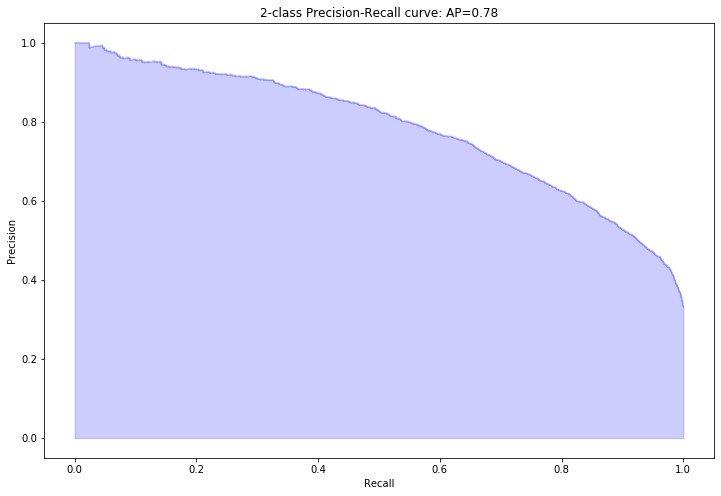

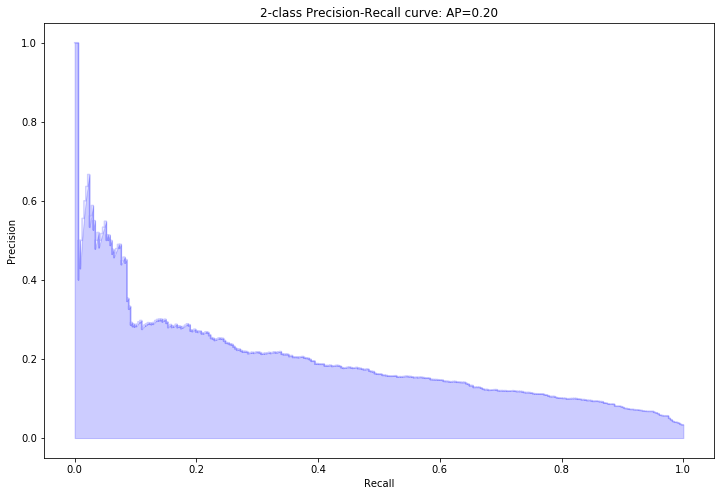

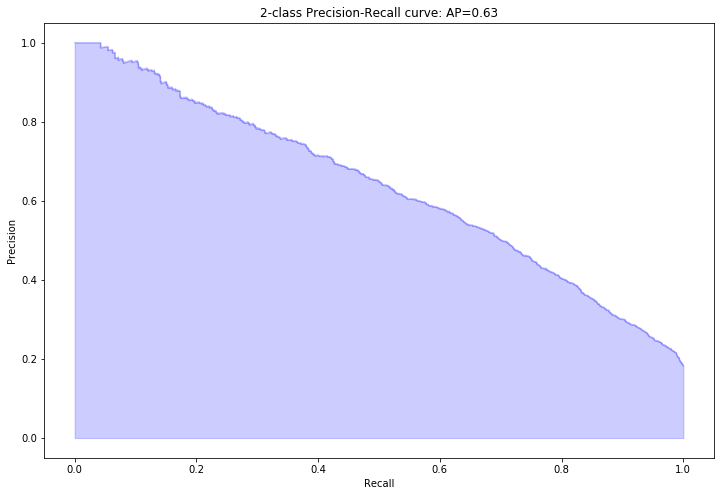

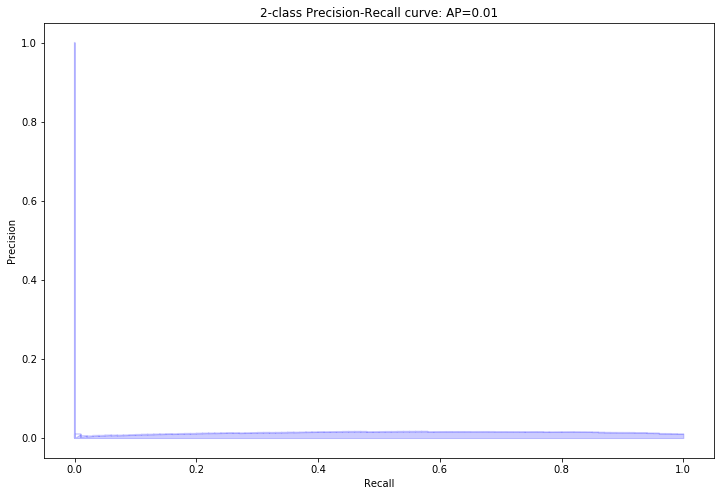

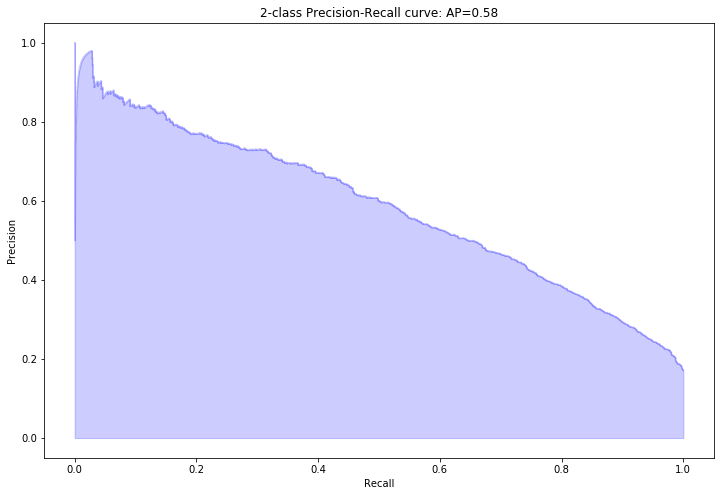

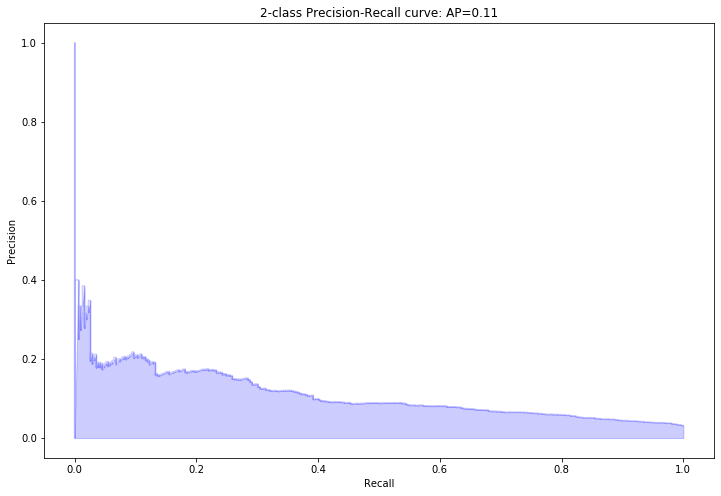

In [130]:
mid_tester(sents_and_labels_mid_test_split)

200 6225
400 6225
600 6225
800 6225
1000 6225
1200 6225
1400 6225
1600 6225
1800 6225
2000 6225
2200 6225
2400 6225
2600 6225
2800 6225
3000 6225
3200 6225
3400 6225
3600 6225
3800 6225
4000 6225
4200 6225
4400 6225
4600 6225
4800 6225
5000 6225
5200 6225
5400 6225
5600 6225
5800 6225
6000 6225
6200 6225
0.7986698123436438
Average precision-recall score: 0.80
0.20337420138161155
Average precision-recall score: 0.20
0.6441531135934514
Average precision-recall score: 0.64
0.01171438174058421
Average precision-recall score: 0.01
0.5766900880650836
Average precision-recall score: 0.58
0.08973951763636713
Average precision-recall score: 0.09


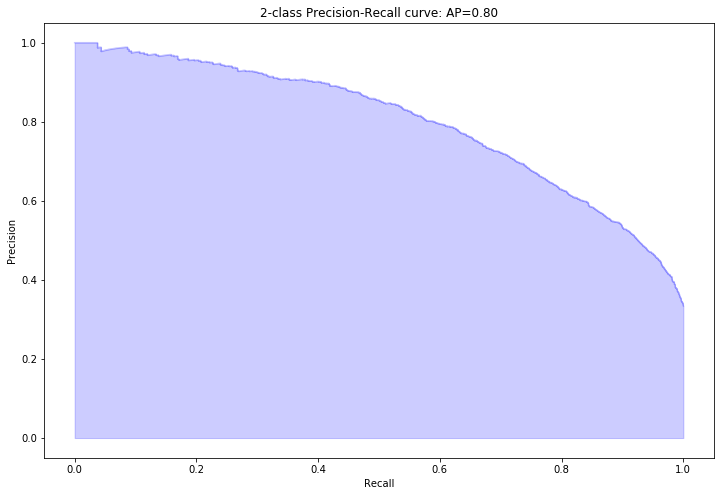

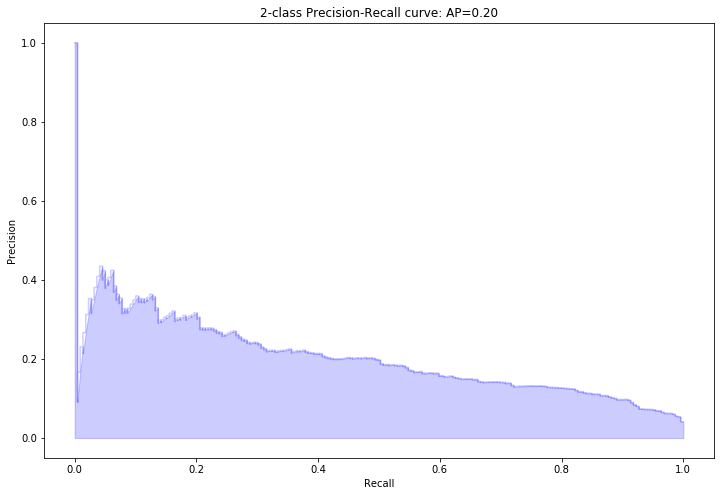

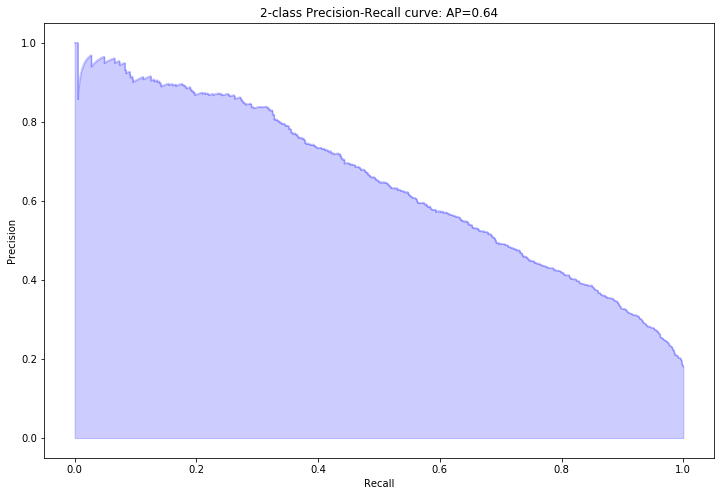

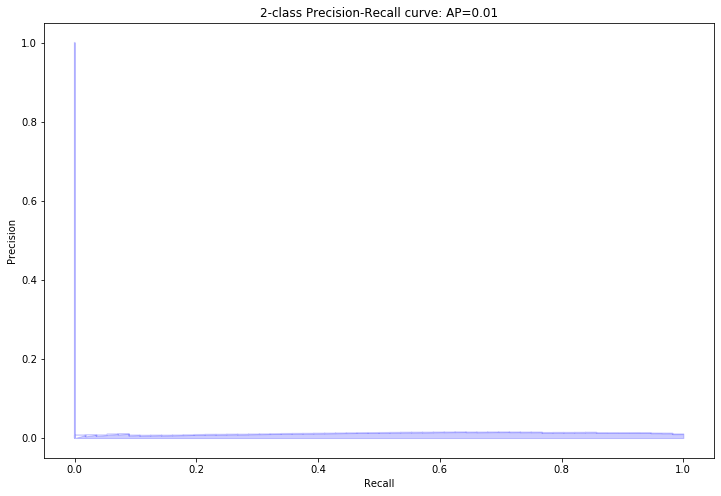

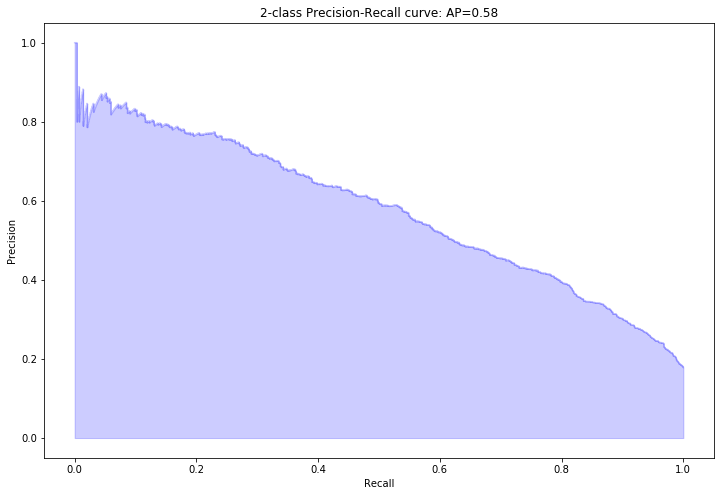

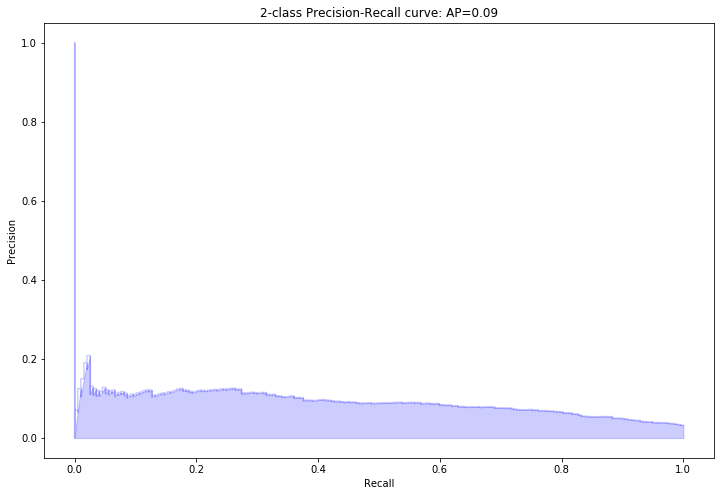

In [19]:
mid_tester(sents_and_labels_test)

In [17]:
model_1 = SimpleRNN(hidden_size)
model_2 = SimpleRNN(hidden_size)
model_3 = SimpleRNN(hidden_size)
model_4 = SimpleRNN(hidden_size)
model_5 = SimpleRNN(hidden_size)
model_6 = SimpleRNN(hidden_size)

model_1.load_state_dict(torch.load('data/model_1.txt'))
model_2.load_state_dict(torch.load('data/model_2.txt'))
model_3.load_state_dict(torch.load('data/model_3.txt'))
model_4.load_state_dict(torch.load('data/model_4.txt'))
model_5.load_state_dict(torch.load('data/model_5.txt'))
model_6.load_state_dict(torch.load('data/model_6.txt'))

<All keys matched successfully>

In [18]:
def process_user_input(input_text,wei):
    list1 = input_text.split(" ")
    #texts = get_embed(list1,wei)
    out = []
    for word in list1:
        W_e = get_embed(word,wei)
        if len(W_e) == 50 :
            out.append(W_e)
    if len(out) > 150:
        out = out[0:150]
    elif len(out) < 150:
        zeros = torch.tensor(np.zeros(50))
        num1 = 150 - len(out)
        while(num1 > 0):
            out.append(zeros)
            num1 -= 1
    return out

## Graphical User Interface ##

In [ ]:
import tkinter as tk

root= tk.Tk()

canvas1 = tk.Canvas(root, width = 700, height = 300,  relief = 'raised')
canvas1.pack()

label1 = tk.Label(root, text='Who is being abusive?')
label1.config(font=('helvetica', 14))
canvas1.create_window(350, 25, window=label1)

label2 = tk.Label(root, text='Person 1 says:')
label2.config(font=('helvetica', 10))
canvas1.create_window(350, 100, window=label2)

label3 = tk.Label(root, text='Person 2 says:')
label3.config(font=('helvetica', 10))
canvas1.create_window(350, 150, window=label3)

entry1 = tk.Entry(root) 
canvas1.create_window(350, 120, window=entry1)
entry2 = tk.Entry(root) 
canvas1.create_window(350, 170, window=entry2)

bully = 'Neither is'
bully_flags = 'civil'
bully_flags2 = ''
def abuse_classifier():
    
    x1 = entry1.get()
    x2 = entry2.get()
    
    
    x1 = re.sub('[^A-Za-z0-9]+', ' ', x1)
    print("this is what goes into the model for prediction", x1)
    input = process_user_input(x1,wei_dict)

    input = [t.numpy() for t in input]###CHANGE
    input = t.tensor(input)
    predic_label = model(input.view(1,150,50))[0]

    if predic_label[0][0] > 0.5000 :
        flags1 = [1, 0, 0, 0, 0, 0]

    else:
        flags1 = [0, 0, 0, 0, 0, 0]

    print(predic_label[0][0])
    
    
    print(flags1)
    
    
    x2 = re.sub('[^A-Za-z0-9]+', ' ', x2)
    print("this is what goes into the model for prediction", x2)
    input1 = process_user_input(x2,wei_dict)

    input1 = [t.numpy() for t in input1]###CHANGE
    input1 = t.tensor(input1)
    predic_label2 = model(input1.view(1,150,50))[0]

    if predic_label2[0][0] > 0.5000 :
        flags2 = [1, 0, 0, 0, 0, 0]

    else:
        flags2 = [0, 0, 0, 0, 0, 0]

    print(predic_label2[0][0])
    
    
    print(flags1)
    
    
    
    bully = 'Neither'
    bully_flags = 'civil'
    bully_flags2 = ''
    flags = ['toxic', 'severely toxic', 'obscene', 'threating', 'insulting', 'identity hating']
    #flags1 = [1, 0, 0, 0, 0, 0]
    #flags2 = [0, 0, 0, 0, 0, 0]
    
    if 1 in flags1 and 1 not in flags2:
        bully = 'Person 1 is'
        bully_flags = ''
        for i in range(len(flags1)):
            if flags1[i] == 1:
                bully_flags += flags[i]
                bully_flags += ', '
        label4.config(text= bully + ' being abusive.')
        label5.config(text= bully + ': ' + bully_flags)
        canvas1.create_window(350, 230, window=label4)
        #canvas1.create_window(350, 250, window=label5)
    
    elif 1 in flags2 and 1 not in flags1:
        bully = 'Person 2 is'
        bully_flags = ''
        for i in range(len(flags2)):
            if flags2[i] == 1:
                bully_flags += flags[i]
                bully_flags += ', '
        label4.config(text= bully + ' being abusive.')
        label5.config(text= bully + ': ' + bully_flags)
        canvas1.create_window(350, 230, window=label4)
        #canvas1.create_window(350, 250, window=label5)
    
    elif 1 in flags1 and 1 in flags2:
        bully = 'Both are'
        bully_flags = ''
        for i in range(len(flags2)):
            if flags1[i] == 1:
                bully_flags += flags[i]
                bully_flags += ', '
            if flags2[i] == 1:
                bully_flags2 += flags[i]
                bully_flags2 += ', '
        label4.config(text= bully + ' being abusive.')
        label5.config(text= 'Person 1: ' + bully_flags)
        label6.config(text= 'Person 2: ' + bully_flags2)
        canvas1.create_window(350, 230, window=label4)
        #canvas1.create_window(350, 250, window=label5)
        #canvas1.create_window(350, 270, window=label6)
    
    elif 1 not in flags1 and 1 not in flags2:
        label4.config(text= bully + ' being abusive.')
        canvas1.create_window(350, 230, window=label4)

label4 = tk.Label(root, text= bully + ' being abusive.', font=('helvetica', 14))
label5 = tk.Label(root, text= bully + ': ' + bully_flags, font=('helvetica', 14))
label6 = tk.Label(root, text = 'Person 2 : ' + bully_flags2, font=('helvetica', 14))
button1 = tk.Button(text='Check', command = abuse_classifier, bg='brown', fg='black', font=('helvetica', 9, 'bold'))
canvas1.create_window(350, 200, window=button1)

root.mainloop()